In [110]:
import pandas as pd
from datetime import datetime, date, timedelta
import pytz
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import glob
import statistics
from scipy import stats
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from statsmodels.distributions.mixture_rvs import mixture_rvs
import statsmodels.api as sm

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import pickle
from statsmodels.iolib.summary2 import summary_col
np.set_printoptions(suppress=True)

import matplotlib.colors as mcolors
import pyreadstat

#Redundant libraries
#import pandas_market_calendars as mcal
#from empyrical import max_drawdown, alpha_beta, sharpe_ratio, alpha, annual_volatility, annual_return, cum_returns


In [4]:
#probably first need to install pyreadstat via pip: pip install pyreadstat
import sys
!{sys.executable} -m pip install pyreadstat

# Read Data

In [23]:
df = pd.read_spss('data.sav')
df

,lfdn,lastpage,quality,duration,country,country_code,eu_country,Estonia_D,Taiwan_D,China_D,...,bta_sub,bta,bta_real1a,bta_real1b,bta_real1,bta_real2a,tor,toe,bta_real2b,bta_real2
0,520.0,5931865.0,NaN,35.0,Taiwan,3.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301.0,5931889.0,NaN,3179.0,Taiwan,3.0,0.0,0.0,1.0,0.0,...,0.32,0.1,0.0,0.32,0.0,-0.24,0.715911,0.55811,0.157801,-0.082199
2,468.0,5931889.0,NaN,1973.0,Taiwan,3.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,937.0,5934355.0,NaN,1373.0,Taiwan,3.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,430.0,5931865.0,NaN,51.0,Taiwan,3.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,589.0,5931867.0,NaN,27.0,Vitnam,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3644,3413.0,5931889.0,NaN,2995.0,Vitnam,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3645,2027.0,5931889.0,NaN,3142.0,Vitnam,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3646,2483.0,5934355.0,NaN,2603.0,Vitnam,5.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
for column in df.columns:
    print(column)

lfdn
lastpage
quality
duration
country
country_code
eu_country
Estonia_D
Taiwan_D
China_D
Vietnam_D
Germany_D
Japan_D
age
gender
female
transgender
job
hdegree
uni_degree
bachelor
master
XD41
major
major_classification
Field_of_graduation
FOG_classification
schoolgrad
grade
unigrade
gradeper_vietnam
gradeper_china
gradeper_taiwan
gradeper_germany
citizen
v_603
resident
v_605
XD9
culture
v_607
Buddhism
Christianity
Confucianism
Islam
Taoism
Marxism
Other_religion
married
parent
children
v_108
XD12
multi_religion
XD13
XD14
household
XD15
hincome
eu_income
eu_ppp_income
USD_ppp_income
income_eu_capita
XGF1
stock
GF1b
wstock
GF1c
GF1d
GF1e
GF1f
GF1g
GF1h
herding
stockm
stockr
fp_zone
D_fp_zone
XR1a
rrp1
rrp2
rrp_gain
rrp_gain_w
XR1b
XR2
lott2
D_lott2
rrp_loss
rrp_loss_w
XR3
theta
theta_w
XR4
ambig
XT1
patient
XHA1
XHA2
XHA3
XHA4
XHA5
XHA6
XHA7
XHA8
XHB11
XHB12a
XHB12b
XHB13
XHB14
XHB15
XHB16
XHB17
XHB18
IDV
PDI
MAS
UAI
XP1
pat
XF1
XF2
XF3
financial_lit
XBN11
XBN12a
XBN12b
XBN13
berlin1
ber

In [6]:
#df = df[df.country != 'Germany']
#df = df[df.country != 'Estonia']
#df

In [7]:
# relevant answers for patriotism and home bias (external variable name (see codebook)) and the nationality

dfr = df[['country','job','parent','uni_degree','patient','XF1','XF2','XF3','female','age','Estonia_D','Taiwan_D','China_D','Vietnam_D','Germany_D','Japan_D','XP1','XFD8','XFD9']]
dfr = dfr.dropna() # drop NaN values
dfr['homebias'] = (dfr['XFD8']-dfr['XFD9'])/(dfr['XFD8']+dfr['XFD9'])
dfr['Home Bias'] = dfr['homebias'].round(2)
dfr['XP1'] = ((-dfr['XP1']+5)-1)/3*2-1
dfr['Patriotism'] = dfr['XP1'].round(2)
dfr['Financial Literacy'] = (np.where(dfr['XF1']== 1, 1, 0)+np.where(dfr['XF2']== 3, 1, 0)+np.where(dfr['XF3']== 2, 1, 0))/3

# subtract capm share from each individual country
dfr['CAPM']=(np.where(dfr['country']== 'Taiwan', 0.0194, 0)+np.where(dfr['country']== 'China', 0.0936, 0)+np.where(dfr['country']== 'japan', 0.0783, 0)+np.where(dfr['country']== 'Vitnam', 0.002, 0)+np.where(dfr['country']== 'Estonia', 0, 0)+np.where(dfr['country']== 'Germany', 0.0260, 0))
dfr['Home Bias 2'] = (dfr['XFD8'])/(dfr['XFD8']+dfr['XFD9'])-dfr['CAPM']
dfr = dfr[dfr.country != 'Germany']
dfr = dfr[dfr.country != 'Estonia']
dfr

,country,job,parent,uni_degree,patient,XF1,XF2,XF3,female,age,...,Japan_D,XP1,XFD8,XFD9,homebias,Home Bias,Patriotism,Financial Literacy,CAPM,Home Bias 2
0,Taiwan,7.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,22.0,...,0.0,0.333333,60.0,40.0,0.200000,0.20,0.33,1.000000,0.0194,0.580600
1,Taiwan,4.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,22.0,...,0.0,0.333333,60.0,40.0,0.200000,0.20,0.33,1.000000,0.0194,0.580600
2,Taiwan,1.0,0.0,0.0,1.0,1.0,3.0,2.0,0.0,18.0,...,0.0,-0.333333,5.0,5.0,0.000000,0.00,-0.33,1.000000,0.0194,0.480600
3,Taiwan,7.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,25.0,...,0.0,-0.333333,25.0,25.0,0.000000,0.00,-0.33,0.333333,0.0194,0.480600
4,Taiwan,2.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,21.0,...,0.0,0.333333,20.0,70.0,-0.555556,-0.56,0.33,0.666667,0.0194,0.202822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639,Vitnam,4.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,34.0,...,0.0,-0.333333,35.0,10.0,0.555556,0.56,-0.33,0.333333,0.0020,0.775778
3640,Vitnam,4.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,26.0,...,0.0,0.333333,10.0,30.0,-0.500000,-0.50,0.33,1.000000,0.0020,0.248000
3644,Vitnam,2.0,0.0,0.0,0.0,1.0,3.0,2.0,0.0,21.0,...,0.0,0.333333,10.0,10.0,0.000000,0.00,0.33,1.000000,0.0020,0.498000
3645,Vitnam,2.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,21.0,...,0.0,-1.000000,10.0,10.0,0.000000,0.00,-1.00,0.666667,0.0020,0.498000


# Data Export (for R script)

In [ ]:
#Export the dataframe to verify the data we used for the regression
dfr.to_csv('relevantdata.csv')

### Export without values that have 0 difference in stocks (home vs abroad)

In [174]:
#Declare the columns we want to extract from the data
column_list = ['country','job','parent','uni_degree','patient',
               'XF1','XF2','XF3','female','age','Estonia_D',
               'Taiwan_D','China_D','Vietnam_D','Germany_D',
               'Japan_D','XP1','XFD8','XFD9']

df_export_nonzero_nan = df[column_list].copy(deep=True)

#Drop the Nan values
#Removes all the XDF8,XDF9 nan values
df_export_nonzero_nan = df_export_nonzero_nan.dropna()

In [175]:
#Removal of XFD8 - XFD9 = 0
#List to store the indexes we want to keep
nonzero_nan_list = []

#Loop all the rows in the dataframe 
for i in range(0,len(df_export_nonzero_nan)):
    
    #Compute the difference between XFD8 and XFD9
    diff = df_export_nonzero_nan.iloc[i]['XFD8'] - df_export_nonzero_nan.iloc[i]['XFD9']
    
    #If the difference between the two is 0
    if(diff != 0):
        #Add the row number to the zero list
        nonzero_nan_list.append(i)

In [176]:
#Set the dataframe with the indexes we want to keep
df_export_nonzero_nan = df_export_nonzero_nan.iloc[nonzero_list].copy(deep=True)

#Reset the index to new numbers based on current length
df_export_nonzero_nan.index = np.arange(0,len(df_export_nonzero_nan),1)

In [206]:
df_export_nonzero_nan.loc[:,'CAPM']=(np.where(df_export_nonzero_nan['country']== 'Taiwan', 0.0194, 0)+
                                     np.where(df_export_nonzero_nan['country']== 'China', 0.0936, 0)+
                                     np.where(df_export_nonzero_nan['country']== 'japan', 0.0783, 0)+
                                     np.where(df_export_nonzero_nan['country']== 'Vitnam', 0.002, 0)+
                                     np.where(df_export_nonzero_nan['country']== 'Estonia', 0, 0)+
                                     np.where(df_export_nonzero_nan['country']== 'Germany', 0.0260, 0))

df_export_nonzero_nan.loc[:,'Home_Bias_2'] = (df_export_nonzero_nan['XFD8'])/(df_export_nonzero_nan['XFD8']+
                                              df_export_nonzero_nan['XFD9'])-df_export_nonzero_nan['CAPM']

In [169]:
pyreadstat.write_sav(df_export_nonzero_nan,'nonzero_nan.sav')

### Exoport without values that have 0 as the base quality

In [219]:
#Declare the columns we want to extract from the data
column_list = ['country','job','parent','uni_degree','patient',
               'XF1','XF2','XF3','female','age','Estonia_D',
               'Taiwan_D','China_D','Vietnam_D','Germany_D',
               'Japan_D','XP1','XFD8','XFD9','base_pack_quality']

df_export_nonzero_quality = df[column_list].copy(deep=True)

#Drop the Nan values
#Removes all the XDF8,XDF9 nan values
df_export_nonzero_quality = df_export_nonzero_quality.dropna()

#Removal of base package quality
#List to store the indexes we want to keep
nonzero_quality_list = []

#Loop all the rows in the dataframe 
for i in range(0,len(df_export_nonzero_quality)):
    
    #If the package 
    if(df_export_nonzero_quality.iloc[i]['base_pack_quality'] != 0):
        #Add the row number to the zero list
        nonzero_quality_list.append(i)
        
#Set the dataframe with the indexes we want to keep
df_export_nonzero_quality = df_export_nonzero_quality.iloc[nonzero_quality_list]

#Reset the index to new numbers based on current length
df_export_nonzero_quality.index = np.arange(0,len(df_export_nonzero_quality),1)

In [220]:
df_export_nonzero_quality.loc[:,'CAPM']=(np.where(df_export_nonzero_quality['country']== 'Taiwan', 0.0194, 0)+
                                         np.where(df_export_nonzero_quality['country']== 'China', 0.0936, 0)+
                                         np.where(df_export_nonzero_quality['country']== 'japan', 0.0783, 0)+
                                         np.where(df_export_nonzero_quality['country']== 'Vitnam', 0.002, 0)+
                                         np.where(df_export_nonzero_quality['country']== 'Estonia', 0, 0)+
                                         np.where(df_export_nonzero_quality['country']== 'Germany', 0.0260, 0))

df_export_nonzero_quality.loc[:,'Home_Bias_2'] = (df_export_nonzero_quality['XFD8'])/(df_export_nonzero_quality['XFD8']+
                                                                                      df_export_nonzero_quality['XFD9'])-df_export_nonzero_quality['CAPM']

In [221]:
pyreadstat.write_sav(df_export_nonzero_quality,'nonzero_quality.sav')

### Export without base quality = 0 and diff = 0

In [223]:
df_export_nonzero_quality_nan = df_export_nonzero_quality.copy(deep=True)

#Removal of XFD8 - XFD9 = 0
#List to store the indexes we want to keep
nonzero_quality_nan_list = []

#Loop all the rows in the dataframe 
for i in range(0,len(df_export_nonzero_quality_nan)):
    
    #Compute the difference between XFD8 and XFD9
    diff = df_export_nonzero_quality_nan.iloc[i]['XFD8'] - df_export_nonzero_quality_nan.iloc[i]['XFD9']
    
    #If the difference between the two is 0
    if(diff != 0):
        #Add the row number to the zero list
        nonzero_quality_nan_list.append(i)
        
#Set the dataframe with the indexes we want to keep
df_export_nonzero_quality_nan = df_export_nonzero_quality_nan.iloc[nonzero_quality_nan_list]

#Reset the index to new numbers based on current length
df_export_nonzero_quality_nan.index = np.arange(0,len(df_export_nonzero_quality_nan),1)

In [224]:
pyreadstat.write_sav(df_export_nonzero_quality_nan,'nonzero_quality_nan.sav')

# Linear Regression

In [8]:
sm.OLS(dfr['Home Bias'],sm.add_constant(dfr[['Patriotism','Financial Literacy','female','age','Taiwan_D','China_D','Vietnam_D','Japan_D']]),missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':1}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Home Bias   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.852
Date:                Sat, 19 Sep 2020   Prob (F-statistic):            0.00377
Time:                        12:29:14   Log-Likelihood:                -1345.3
No. Observations:                1607   AIC:                             2709.
Df Residuals:                    1598   BIC:                             2757.
Df Model:                           8                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1988      0.140     -1.424      0.154      -0.472       0.075
Patriotism             0.0540      0.027      2.022      0.043       0.002       0.106
Financial Literacy    -0.0043      0.049     -0.087      0.931      -0.101       0.093
female                 0.0503      0.029      1.736      0.083      -0.007       0.107
age                    0.0040      0.003      1.551      0.121      -0.001       0.009
Taiwan_D               0.0629      0.119      0.530      0.596      -0.170       0.296
China_D                0.1348      0.119      1.133      0.257      -0.098       0.368
Vietnam_D              0.1686      0.120      1.403      0.161      -0.067       0.404
Japan_D                0.1470      0.125      1.173      0.241      -0.099       0.393
==============================================================================
Omnibus:                       14.011   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.563
Skew:                           0.026   Prob(JB):                      0.00838
Kurtosis:                       2.626   Cond. No.                         748.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

# Plots

<AxesSubplot:>

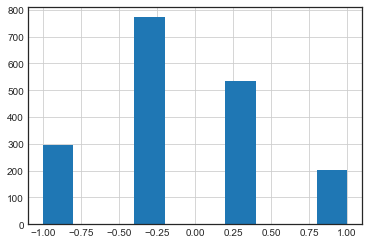

In [10]:
dfr['XP1'].hist()

In [11]:
country_name = []
country_XP1 = []

for country in df['country'].unique():
    country_name.append(country)
    country_XP1.append(df.loc[df['country'] == country]['XP1'])

In [12]:
country_XP1_percentages = []

for country in country_XP1:
    
    count_bins = np.zeros(4)
    
    counter = 0
    
    for i in country:
        if(i.is_integer()):
            count_bins[int(i)-1] += 1
            counter += 1
    
    country_XP1_percentages.append(count_bins/counter)


In [14]:
def plot_Choices_countries(data, country_labels, choices):


    xAxis = np.arange(choices[0]-0.4,choices[1]+0.6,1.0)

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    rows = len(data)

    for i in range(0,rows):
        ax.bar(xAxis+((0.8/rows)*i),data[i], width= (0.8/rows))

    ax.set_ylabel('Percentage')
    ax.set_xlabel('Choice Selected')
    ax.set_xticks(np.arange(choices[0],choices[1]+1))
    ax.set_yticks(np.arange(0,data.max()+0.1,0.1))
    ax.legend(labels=country_labels)
    plt.show()

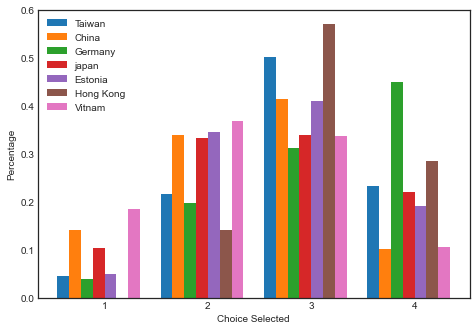

In [19]:
# Distribution of the patriotism variable in each country - professor comment during presentation
#Plot for this below

# Perhaps add black bars around each bar - B
plot_Choices_countries(np.array(country_XP1_percentages),country_name,[1,4])

Taiwan  has 30 nan values with 707 respondents, so a 0.04 percentage of nan values


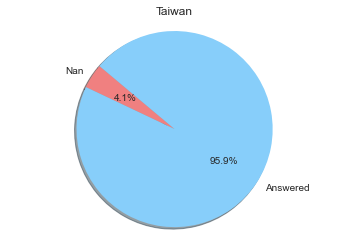

China  has 161 nan values with 729 respondents, so a 0.22 percentage of nan values


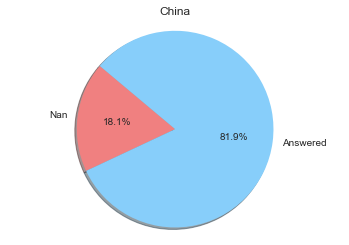

Germany  has 274 nan values with 916 respondents, so a 0.3 percentage of nan values


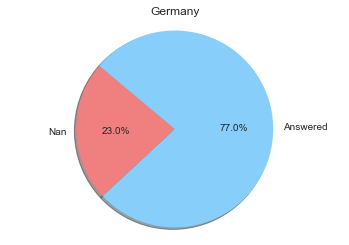

japan  has 95 nan values with 226 respondents, so a 0.42 percentage of nan values


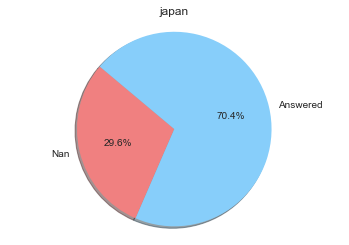

Estonia  has 53 nan values with 115 respondents, so a 0.46 percentage of nan values


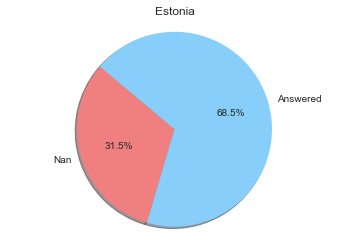

Hong Kong  has 11 nan values with 23 respondents, so a 0.48 percentage of nan values


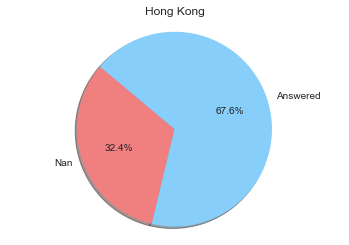

Vitnam  has 507 nan values with 932 respondents, so a 0.54 percentage of nan values


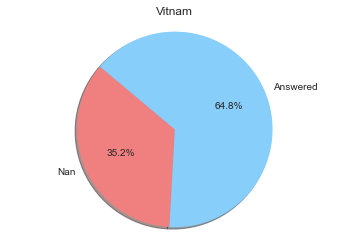

In [16]:
for country in df['country'].unique():
    country_data = df.loc[df['country'] == country]
    nan_count = len(np.where(country_data['XFD8'].isnull())[0])
    resp_sum = len(country_data['XFD8'])
    
    print(country," has "+str(nan_count)+" nan values with "+str(resp_sum)+" respondents, so a "+str(round(nan_count/resp_sum,2))+" percentage of nan values")
    
    # Data to plot
    labels = 'Nan','Answered'
    sizes = [nan_count, resp_sum]
    colors = ['lightcoral', 'lightskyblue']

    # Plot
    plt.title(country)
    plt.pie(sizes, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

In [ ]:
#TODO
# Female / Male per country